In [1]:
import json, pprint, collections
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from datetime import time, timedelta, timezone, datetime


In [2]:
f = open('../data/model_build_inputs/route_data.json')
route_data = json.load(f)

f = open('../data/model_build_inputs/package_data.json')
p_data = json.load(f)

f = open('../data/model_build_inputs/actual_sequences.json')
act_seq = json.load(f)

f = open('../data/model_build_inputs/travel_times.json')
dist_data = json.load(f)

## Basic Statistics

### Location Information

In [3]:
from sklearn.cluster import KMeans

locs = []
for k,v in route_data.items():
    stop = next(iter(v['stops'].values()))
    locs.append((stop['lat'], stop['lng']))

kmeans = KMeans(n_clusters=5).fit(locs)
centers = kmeans.cluster_centers_

label = kmeans.labels_
unique, counts = np.unique(label, return_counts=True)

metros = ['Los Angeles', 'Chicago', 'Seattle', 'Boston', 'Austin']
index_to_metro = {}

# from geopy.geocoders import Nominatim
# geolocator = Nominatim(user_agent="here")
# metro_to_loc = {}
# for m in metros:
#     location = geolocator.geocode(m)
#     metro_to_loc[m] = [location.latitude, location.longitude]
    
metro_to_loc = {'Los Angeles': [34.0536909, -118.242766],
     'Chicago': [41.8755616, -87.6244212],
     'Seattle': [47.6038321, -122.3300624],
     'Boston': [42.3602534, -71.0582912],
     'Austin': [30.2711286, -97.7436995]}

for m in metros:
    loc = metro_to_loc[m]
    dist = np.linalg.norm(centers - loc, axis=1)
    index = np.argmin(dist)
    index_to_metro[index] = m
    print(m + ': ' + str(counts[index]))

Los Angeles: 2888
Chicago: 1002
Seattle: 1079
Boston: 929
Austin: 214


### Route data statistics

In [4]:
timedelta_from_utc = {'Los Angeles': 7, 'Boston': 4, 'Seattle': 7, 'Austin': 5, 'Chicago': 5}

metro_to_stations = {}
metro_route_data = collections.defaultdict(dict)

for k,v in route_data.items():
    stop = next(iter(v['stops'].values()))
    loc = (stop['lat'], stop['lng'])
    dist = np.linalg.norm(centers - loc, axis=1)
    index = np.argmin(dist)
    metro_route_data[index_to_metro[index]][k] = v

for m in metros:
    print(m + ':')
    d = metro_route_data[m]

    stations = set()
    caps = set()
    date = set()
    dep_time = set()
    scores = []

    for k,v in d.items():
        stations.add(v['station_code'])
        caps.add(v['executor_capacity_cm3'])
        date.add(v['date_YYYY_MM_DD'])
        dep_time.add(v['departure_time_utc'])
        scores.append(v['route_score'])
        s_dict = collections.Counter(scores)
        
    metro_to_stations[m] = sorted(stations)
    
    print('no. pickup stations: {} - {}'.format(len(stations), stations))
    print('no. truck types: {} - {}'.format(len(caps), sorted(caps)))
    print('route scores: High - {}, Medium - {}, Low - {}'.format(s_dict['High'], s_dict['Medium'], s_dict['Low']))
    print('dates: start - {}, end - {}'.format(min(date), max(date)))
    
    t = datetime.fromisoformat('2018-07-19 ' + min(dep_time)) + timedelta(hours=-timedelta_from_utc[m])
    min_time = t.time().isoformat()
    t = datetime.fromisoformat('2018-07-19 ' + max(dep_time)) + timedelta(hours=-timedelta_from_utc[m])
    max_time = t.time().isoformat()
    print('departure time (local): start - {}, end - {}'.format(min_time, max_time))

Los Angeles:
no. pickup stations: 6 - {'DLA8', 'DLA7', 'DLA9', 'DLA3', 'DLA5', 'DLA4'}
no. truck types: 3 - [3114853.25, 3313071.0, 4247527.0]
route scores: High - 1393, Medium - 1438, Low - 57
dates: start - 2018-07-19, end - 2018-08-26
departure time (local): start - 06:20:38, end - 11:27:10
Chicago:
no. pickup stations: 4 - {'DCH2', 'DCH3', 'DCH1', 'DCH4'}
no. truck types: 2 - [3313071.0, 4247527.0]
route scores: High - 381, Medium - 609, Low - 12
dates: start - 2018-07-19, end - 2018-08-17
departure time (local): start - 06:58:55, end - 11:29:08
Seattle:
no. pickup stations: 3 - {'DSE5', 'DSE2', 'DSE4'}
no. truck types: 3 - [3114853.25, 3313071.0, 4247527.0]
route scores: High - 542, Medium - 521, Low - 16
dates: start - 2018-07-19, end - 2018-08-26
departure time (local): start - 06:18:59, end - 10:16:53
Boston:
no. pickup stations: 3 - {'DBO1', 'DBO3', 'DBO2'}
no. truck types: 2 - [3313071.0, 4247527.0]
route scores: High - 306, Medium - 610, Low - 13
dates: start - 2018-07-20, e

In [5]:
station_to_id = collections.defaultdict(list)
for k,v in route_data.items():
    code = v['station_code']
    station_to_id[code].append(k)

for m in metros:
    for code in metro_to_stations[m]:
        print('stats for station {}'.format(code))
        
        route_len = []
        packet_len = []
        max_packet_stop = []
        packet_undeliver_len = []
        for k, v in p_data.items():
            if k in station_to_id[code]:
                seq = act_seq[k]['actual']
                len_seq = len(seq) - 1
                route_len.append(len_seq)
                stop_packet_len = []
                stop_undeliver_packets = []
                for stop, packages in v.items():
                        
                    stop_packet_len.append(len(packages))
                    cnt = 0
                    for _, pack in packages.items():
                        if pack['scan_status'] != 'DELIVERED':
                            cnt += 1
                    stop_undeliver_packets.append(cnt)
                packet_len.append(sum(stop_packet_len))
                max_packet_stop.append(max(stop_packet_len))
                packet_undeliver_len.append(sum(stop_undeliver_packets))
                
        print('total # routes: {}'.format(len(route_len)))
        print('average, min, max # dropoff stops: {}, {}, {}'.format(
            np.mean(route_len), min(route_len), max(route_len)))
        print('average, min, max # packages: {}, {}, {}'.format(
            np.mean(packet_len), min(packet_len), max(packet_len)))
        print('average # packages per stop: {}'.format(np.mean(packet_len) / np.mean(route_len)))
        print('')

stats for station DLA3
total # routes: 254
average, min, max # dropoff stops: 116.12992125984252, 45, 189
average, min, max # packages: 222.751968503937, 150, 294
average # packages per stop: 1.9181272671797132

stats for station DLA4
total # routes: 197
average, min, max # dropoff stops: 137.23350253807106, 62, 201
average, min, max # packages: 237.45685279187816, 150, 296
average # packages per stop: 1.7303125577954503

stats for station DLA5
total # routes: 155
average, min, max # dropoff stops: 166.0774193548387, 99, 213
average, min, max # packages: 245.66451612903225, 162, 297
average # packages per stop: 1.47921684406806

stats for station DLA7
total # routes: 1133
average, min, max # dropoff stops: 153.34333627537512, 87, 208
average, min, max # packages: 233.27625772285967, 155, 299
average # packages per stop: 1.5212676558956588

stats for station DLA8
total # routes: 448
average, min, max # dropoff stops: 128.03348214285714, 48, 193
average, min, max # packages: 248.11160714

Other observations:
    
    1) Stop ID is unique to each route.
    2) Zone ID is unique to each pickup station.
    3) The first stop of each route is always the pickup station (no package dropoffs).

## Time Window vs Sequence Order

First, let us look at the distribution of time windows. Note that only ~10% packages are given a time window.

stats for station DLA3
package window distribution:


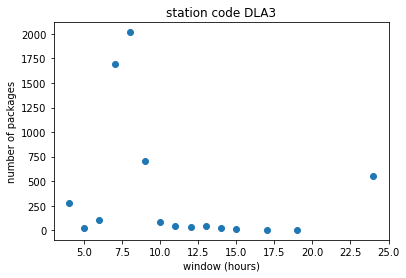

ratio of packages with window - 5610/56579 = 0.0992

stats for station DLA4
package window distribution:


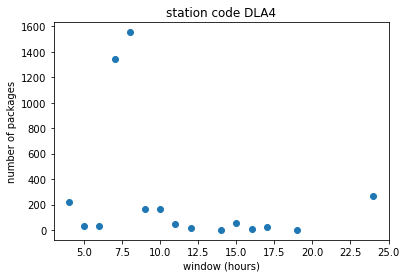

ratio of packages with window - 3934/46779 = 0.0841

stats for station DLA5
package window distribution:


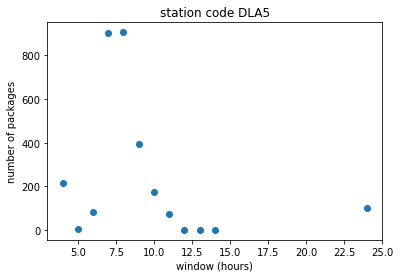

ratio of packages with window - 2852/38078 = 0.0749

stats for station DLA7
package window distribution:


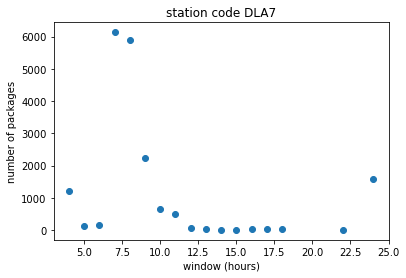

ratio of packages with window - 18694/264302 = 0.0707

stats for station DLA8
package window distribution:


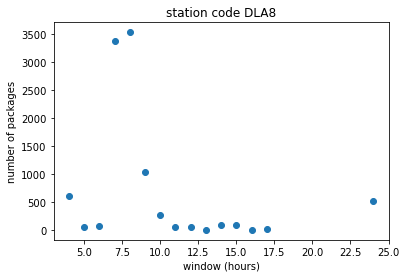

ratio of packages with window - 9765/111154 = 0.0879

stats for station DLA9
package window distribution:


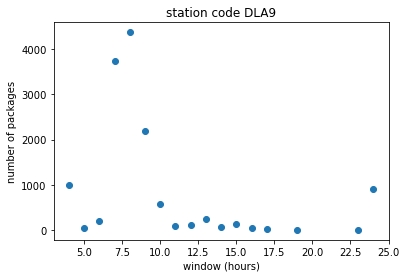

ratio of packages with window - 13744/173480 = 0.0792

stats for station DCH1
package window distribution:


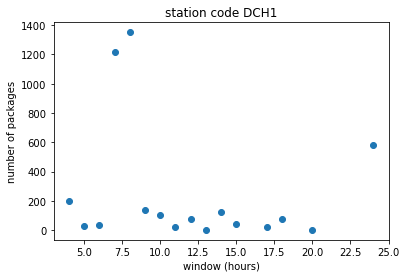

ratio of packages with window - 4024/47265 = 0.0851

stats for station DCH2
package window distribution:


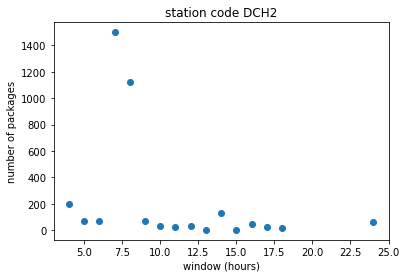

ratio of packages with window - 3383/41386 = 0.0817

stats for station DCH3
package window distribution:


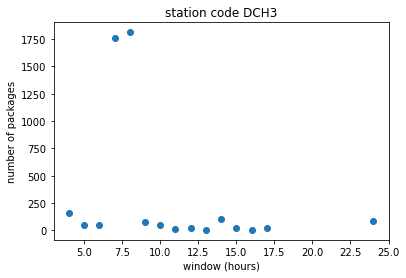

ratio of packages with window - 4226/70379 = 0.0600

stats for station DCH4
package window distribution:


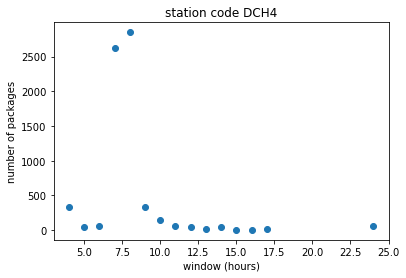

ratio of packages with window - 6681/93511 = 0.0714

stats for station DSE2
package window distribution:


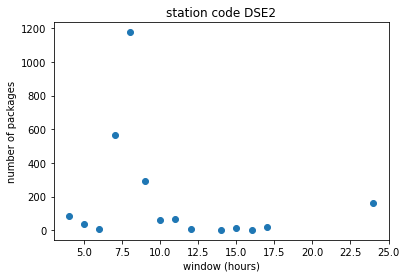

ratio of packages with window - 2497/27022 = 0.0924

stats for station DSE4
package window distribution:


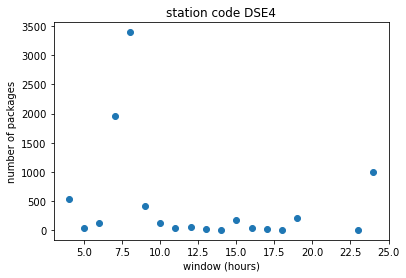

ratio of packages with window - 8121/107384 = 0.0756

stats for station DSE5
package window distribution:


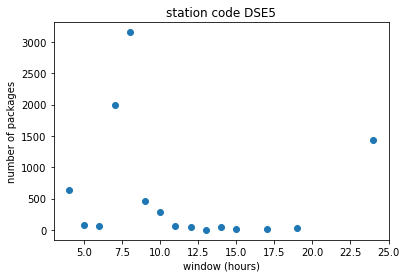

ratio of packages with window - 8337/115050 = 0.0725

stats for station DBO1
package window distribution:


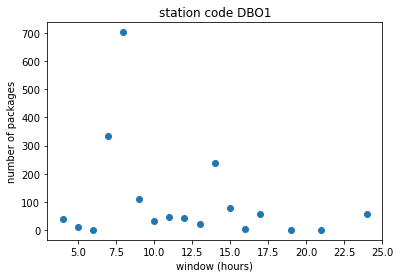

ratio of packages with window - 1784/15335 = 0.1163

stats for station DBO2
package window distribution:


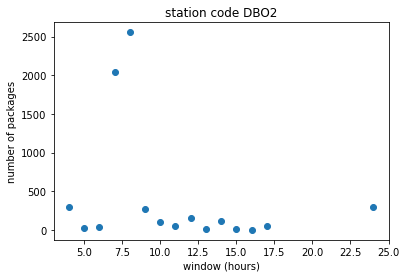

ratio of packages with window - 6024/70536 = 0.0854

stats for station DBO3
package window distribution:


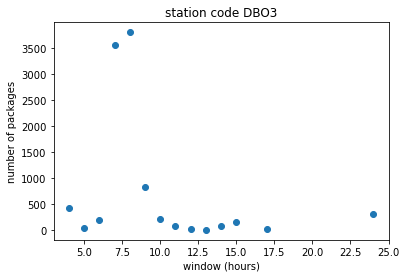

ratio of packages with window - 9747/128017 = 0.0761

stats for station DAU1
package window distribution:


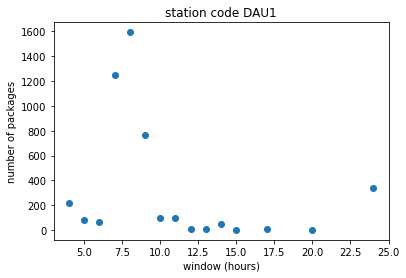

ratio of packages with window - 4570/50918 = 0.0898



In [6]:
for m in metros:
    for code in metro_to_stations[m]:
        print('stats for station {}'.format(code))

        limit, no_limit = 0, 0
        delta_list = []
        for k, v in p_data.items():
            if k in station_to_id[code]:
                for stop, packages in v.items():
                    for pid, pinfo in packages.items():
                        if type(pinfo['time_window']['end_time_utc']) == type('a'):
                            end = datetime.fromisoformat(pinfo['time_window']['end_time_utc'])
                            start = datetime.fromisoformat(pinfo['time_window']['start_time_utc'])
                            delta = (end-start).seconds
                            delta_list.append(delta)
                            limit += 1
                        else:
                            no_limit += 1

        unique, counts = np.unique(delta_list, return_counts=True)
        counter_dict = collections.defaultdict(int)
        for u, c in zip(unique, counts):
            counter_dict[int(round(u / 3600))] += c
        x, y = zip(*counter_dict.items())
        
        print('package window distribution:')
        plt.scatter(x, y)
        plt.ylabel('number of packages')
        plt.xlabel('window (hours)')
        plt.title('station code {}'.format(code))
        plt.show()

        total = limit + no_limit
        print('ratio of packages with window - {}/{} = {:.4f}'.format(limit, total, limit / total))
        print('')

We can define the *time window of a stop* as the largest window that satisfies the time requirements of all packages (e.g., [[2,5], [3,6]] --> [3,5]). It turns out only one stop has a window = 0 and all the other windows are greater than 0. Again, we look at the distribution of (stop) windows.

stats for station DLA3
package window distribution:


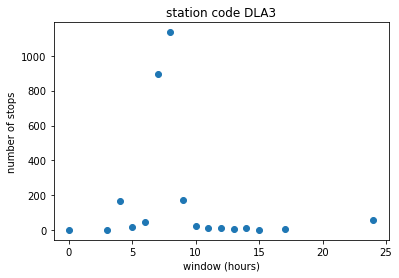

ratio of stops with window - 2566/29751 = 0.0862
smallest window: 0.0

stats for station DLA4
package window distribution:


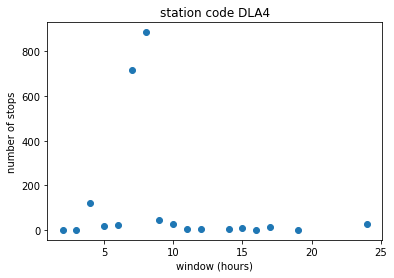

ratio of stops with window - 1900/27232 = 0.0698
smallest window: 2.5

stats for station DLA5
package window distribution:


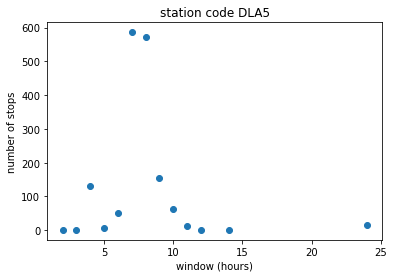

ratio of stops with window - 1601/25897 = 0.0618
smallest window: 2.0

stats for station DLA7
package window distribution:


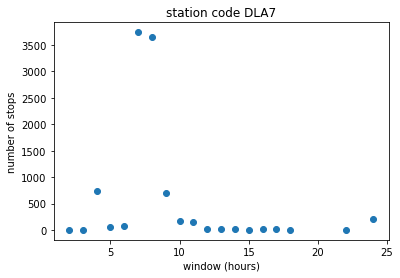

ratio of stops with window - 9578/174871 = 0.0548
smallest window: 2.0

stats for station DLA8
package window distribution:


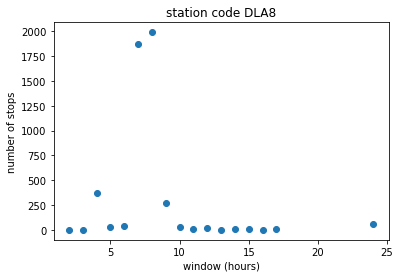

ratio of stops with window - 4744/57807 = 0.0821
smallest window: 2.0

stats for station DLA9
package window distribution:


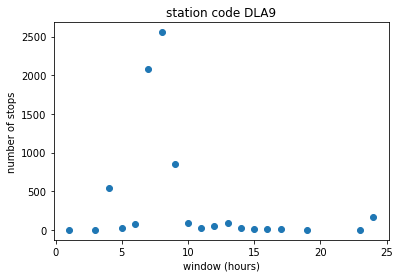

ratio of stops with window - 6644/98882 = 0.0672
smallest window: 1.0

stats for station DCH1
package window distribution:


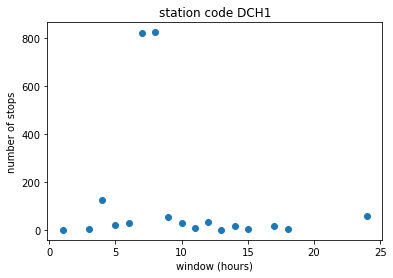

ratio of stops with window - 2054/24394 = 0.0842
smallest window: 1.0

stats for station DCH2
package window distribution:


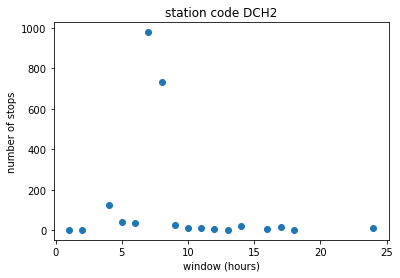

ratio of stops with window - 2023/23905 = 0.0846
smallest window: 1.0

stats for station DCH3
package window distribution:


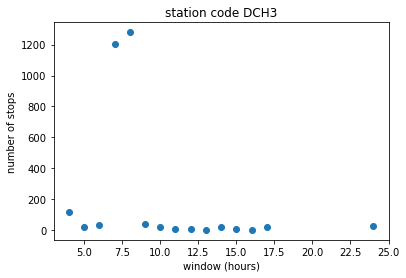

ratio of stops with window - 2810/50180 = 0.0560
smallest window: 4.0

stats for station DCH4
package window distribution:


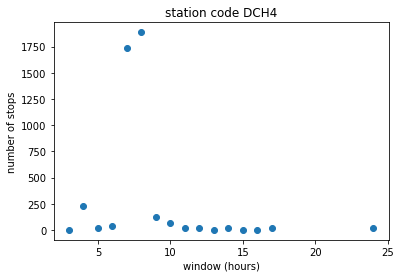

ratio of stops with window - 4209/63931 = 0.0658
smallest window: 3.0

stats for station DSE2
package window distribution:


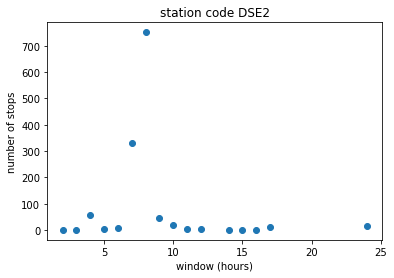

ratio of stops with window - 1260/13087 = 0.0963
smallest window: 2.0

stats for station DSE4
package window distribution:


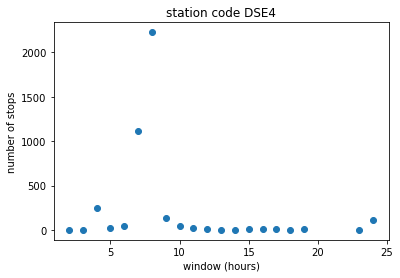

ratio of stops with window - 4043/64147 = 0.0630
smallest window: 2.0

stats for station DSE5
package window distribution:


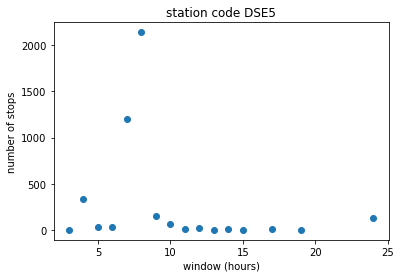

ratio of stops with window - 4150/78547 = 0.0528
smallest window: 3.0

stats for station DBO1
package window distribution:


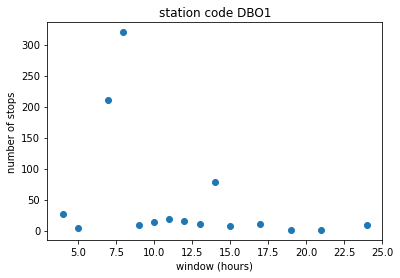

ratio of stops with window - 736/8265 = 0.0891
smallest window: 4.0

stats for station DBO2
package window distribution:


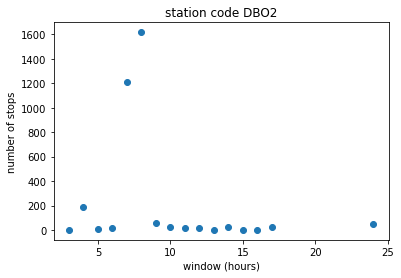

ratio of stops with window - 3255/41422 = 0.0786
smallest window: 3.0

stats for station DBO3
package window distribution:


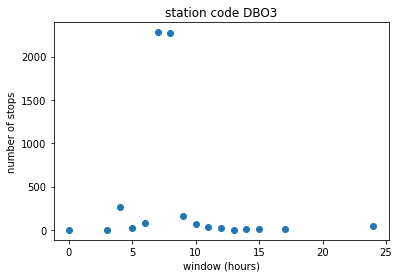

ratio of stops with window - 5322/90935 = 0.0585
smallest window: 0.5

stats for station DAU1
package window distribution:


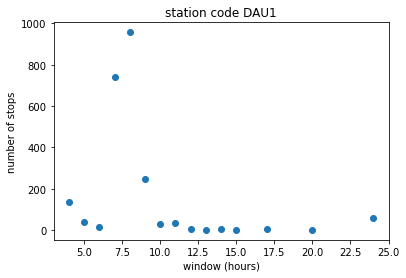

ratio of stops with window - 2277/31274 = 0.0728
smallest window: 4.0



In [7]:
for m in metros:
    for code in metro_to_stations[m]:
        print('stats for station {}'.format(code))

        limit, no_limit = 0, 0
        delta_list = []
        for k, v in p_data.items():
            if k in station_to_id[code]:
                for stop, packages in v.items():
                    end_stop = datetime.max
                    start_stop = datetime.min
                    delta_max = end_stop - start_stop
                    for pid, pinfo in packages.items():
                        if type(pinfo['time_window']['end_time_utc']) == type('a'):
                            end = datetime.fromisoformat(pinfo['time_window']['end_time_utc'])
                            start = datetime.fromisoformat(pinfo['time_window']['start_time_utc'])
                            end_stop = min(end, end_stop)
                            start_stop = max(start, start_stop)
                    delta = (end_stop - start_stop)
                    if delta < delta_max:
                        delta_list.append(delta.total_seconds())
                        limit += 1
                    else:
                        no_limit += 1

        unique, counts = np.unique(delta_list, return_counts=True)
        counter_dict = collections.defaultdict(int)
        for u, c in zip(unique, counts):
            counter_dict[int(round(u / 3600))] += c
        x, y = zip(*counter_dict.items())
        
        print('package window distribution:')
        plt.scatter(x, y)
        plt.ylabel('number of stops')
        plt.xlabel('window (hours)')
        plt.title('station code {}'.format(code))
        plt.show()

        total = limit + no_limit
        print('ratio of stops with window - {}/{} = {:.4f}'.format(limit, total, limit / total))
        print('smallest window: {}\n'.format(min(delta_list) / 3600))


Next, we define *Urgency* of a stop as *stop_window_end - departure_time*, and *Latency* as *stop_window_start - departure_time*. We aggregate route data with same score level and plot *relative delivery order vs urgency/latency of each stop* (scatter and boxplot).

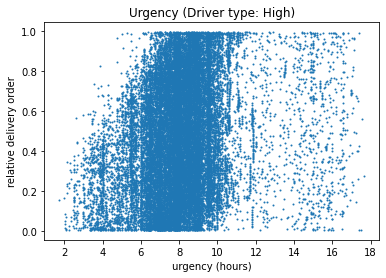

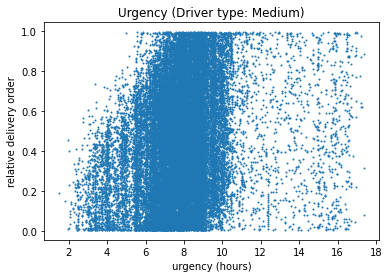

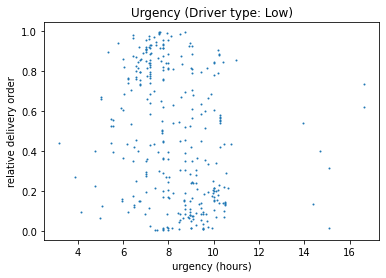

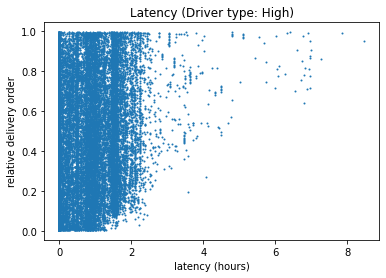

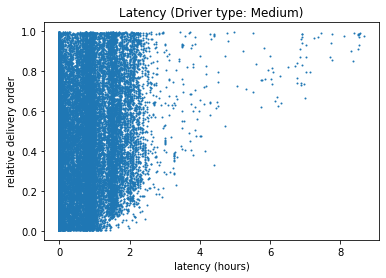

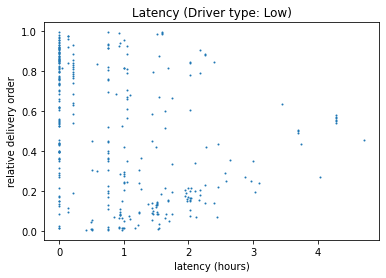

In [8]:
order_urgency = collections.defaultdict(list)
order_latency = collections.defaultdict(list)

for k, v in p_data.items():
#     if k in station_to_code[code]:
    seq = act_seq[k]['actual']
    len_seq = len(seq)
    r_score = route_data[k]['route_score']
    route_start = datetime.fromisoformat(
        route_data[k]['date_YYYY_MM_DD'] + ' ' + route_data[k]['departure_time_utc'])
    for stop, packages in v.items():
        order = seq[stop]
        end_stop = datetime.max
        start_stop = datetime.min
        delta_max = end_stop - start_stop
        for pid, pinfo in packages.items():
            if type(pinfo['time_window']['end_time_utc']) == type('a'):
                end = datetime.fromisoformat(pinfo['time_window']['end_time_utc'])
                start = datetime.fromisoformat(pinfo['time_window']['start_time_utc'])
                end_stop = min(end, end_stop)
                start_stop = max(start, start_stop)
        delta0 = (end_stop - start_stop)
        if delta0 < delta_max:
            delta = (end_stop-route_start).total_seconds()
            order_urgency[r_score].append([order / len_seq, delta / 3600])
            delta = max(0, (start_stop-route_start).total_seconds())
            order_latency[r_score].append([order / len_seq, delta / 3600])
                
scores = ['High', 'Medium', 'Low']

for t in scores:
    a,b = (zip(*order_urgency[t]))
    plt.scatter(b, a, s=1)
    plt.title('Urgency (Driver type: {})'.format(t))
    plt.xlabel('urgency (hours)')
    plt.ylabel('relative delivery order')
    plt.show()

for t in scores:
    a,b = (zip(*order_latency[t]))
    plt.scatter(b, a, s=1)
    plt.title('Latency (Driver type: {})'.format(t))
    plt.xlabel('latency (hours)')
    plt.ylabel('relative delivery order')
    plt.show()

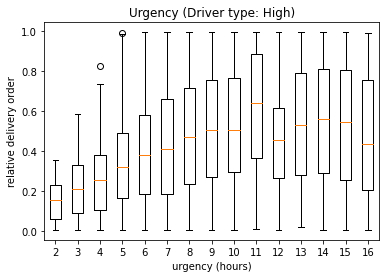

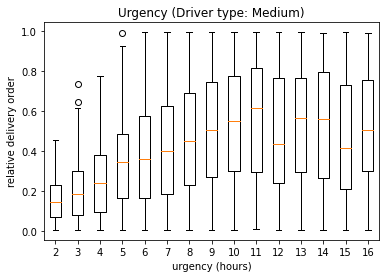

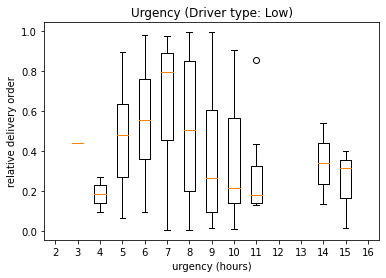

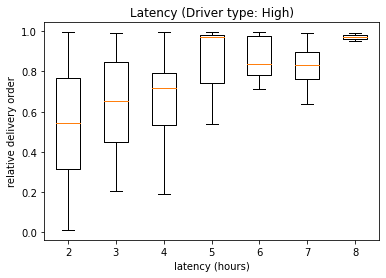

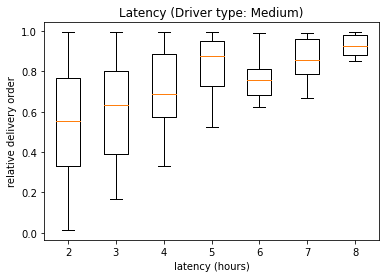

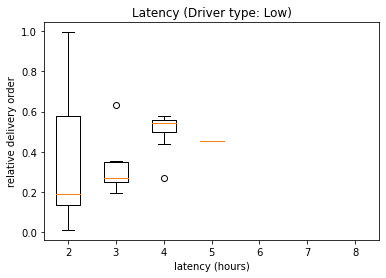

In [9]:
for t in ['High', 'Medium', 'Low']:
    boxplot = collections.defaultdict(list)
    
    for order, hour in order_urgency[t]:
        boxplot[int(round(hour))].append(order)
        
    box_data = [boxplot[i] for i in range(2,17)]
    label = np.linspace(2,16,15).astype(int)
    
    plt.boxplot(box_data, labels=label)
    
    
    plt.title('Urgency (Driver type: {})'.format(t))
    plt.xlabel('urgency (hours)')
    plt.ylabel('relative delivery order')
    plt.show()

    
for t in ['High', 'Medium', 'Low']:
    boxplot = collections.defaultdict(list)
    
    for order, hour in order_latency[t]:
        boxplot[int(round(hour))].append(order)
        
    box_data = [boxplot[i] for i in range(2,9)]
    label = np.linspace(2,8,7).astype(int)
    
    plt.boxplot(box_data, labels=label)
    
    
    plt.title('Latency (Driver type: {})'.format(t))
    plt.xlabel('latency (hours)')
    plt.ylabel('relative delivery order')
    plt.show()

## Stop Package Sum vs Sequence Order

Stop package sum = the number of packages of a stop

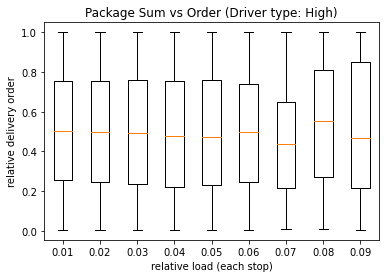

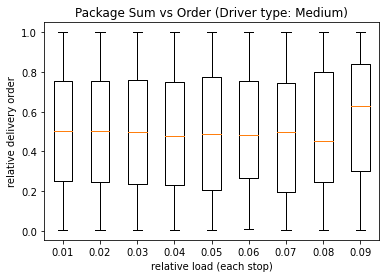

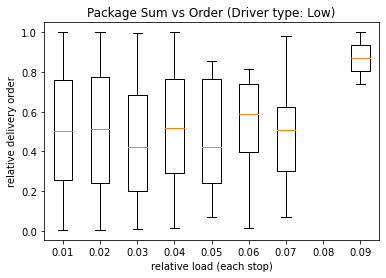

In [10]:
order_packetnum = collections.defaultdict(list)

for k, v in p_data.items():
    r_score = route_data[k]['route_score']
    seq = act_seq[k]['actual']
    len_seq = len(seq) - 1
    route_len.append(len_seq)

    tot = 0
    for stop, packages in v.items():
        tot += len(packages)
    for stop, packages in v.items():  
        if len(packages) != 0:
            order = seq[stop]
            order_packetnum[r_score].append([order / len_seq, len(packages) / tot])
    
for t in ['High', 'Medium', 'Low']:
    boxplot = collections.defaultdict(list)
    
    for order, ratio in order_packetnum[t]:
        boxplot[int(round(ratio * 100))].append(order)
        
    box_data = [boxplot[i] for i in range(1,10)]
    label = np.around(np.linspace(0.01,0.09,9), 2)
    
    plt.boxplot(box_data, labels=label)
    
    
    plt.title('Package Sum vs Order (Driver type: {})'.format(t))
    plt.xlabel('relative load (each stop)')
    plt.ylabel('relative delivery order')
    plt.show()

## Packet Size vs Sequence Order

In [11]:
order_packetsize = collections.defaultdict(list)
sizes = []

for k, v in p_data.items():
    r_score = route_data[k]['route_score']
    seq = act_seq[k]['actual']
    len_seq = len(seq) - 1
    tot = 0

    for stop, packages in v.items():  
        if len(packages) != 0:
            order = seq[stop]
            for p in packages.values():
                size = np.prod(list(p['dimensions'].values()))
                sizes.append(size)
                order_packetsize[r_score].append([order / len_seq, size])


First, let us look at the distribution of package sizes:

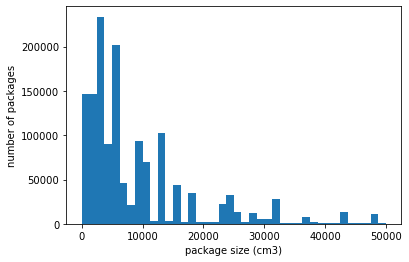

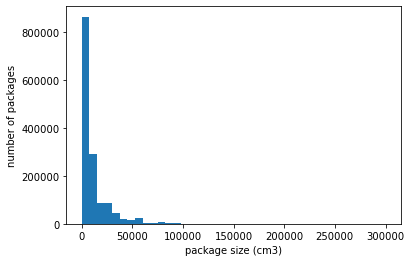

In [12]:
plt.hist(sizes, bins = 40, range=[0, 50000])
plt.xlabel('package size (cm3)')
plt.ylabel('number of packages')
plt.show()
plt.hist(sizes, bins = 40)
plt.xlabel('package size (cm3)')
plt.ylabel('number of packages')
plt.show()

Boxplot (size vs order)

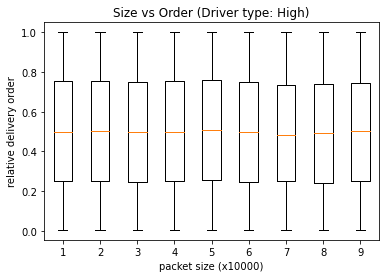

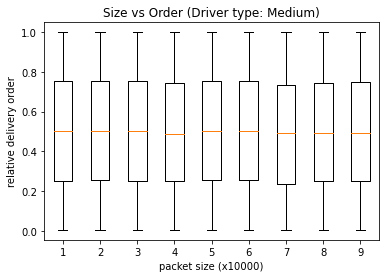

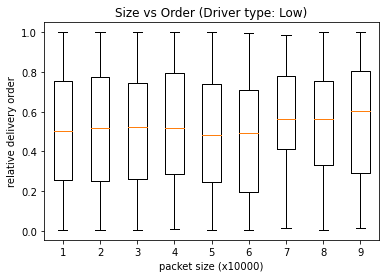

In [13]:
for t in ['High', 'Medium', 'Low']:
    boxplot = collections.defaultdict(list)
    
    for order, size in order_packetsize[t]:
        boxplot[int(round(size / 10000))].append(order)
        
    box_data = [boxplot[i] for i in range(1,10)]
    label = np.linspace(1,9,9).astype(int)
    
    plt.boxplot(box_data, labels=label)

    plt.title('Size vs Order (Driver type: {})'.format(t))
    plt.xlabel('packet size (x10000)')
    plt.ylabel('relative delivery order')
    plt.show()

## Compare total travel time (High vs Medium drivers)

Note that it is hard to compare directly since we do not have routes chosen by drivers with different levels **on the same task**.

In the following, I draw scatter plots (of different locations) with each dot representing *(number of stops, total travel time)* of a route.

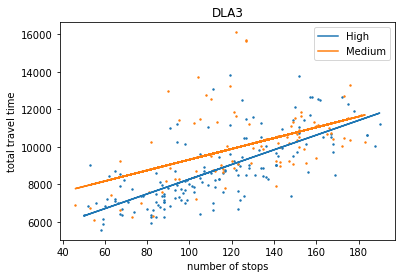

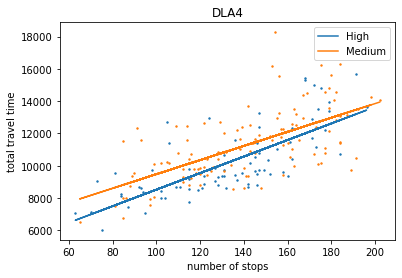

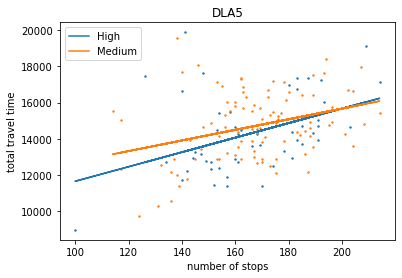

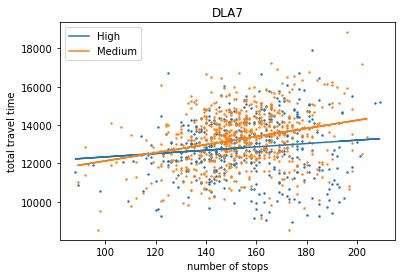

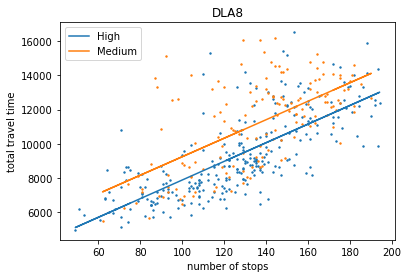

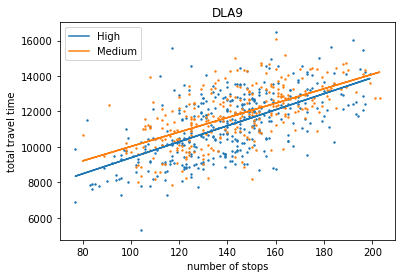

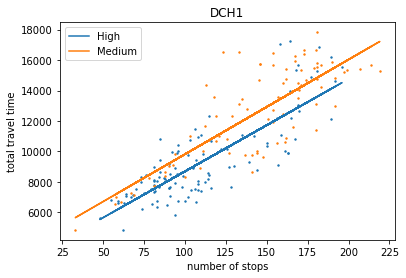

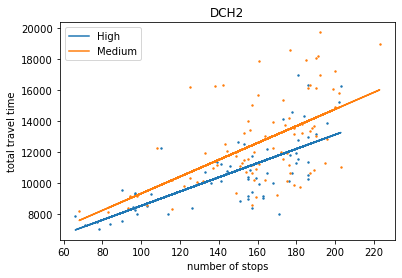

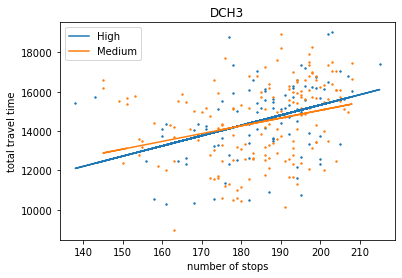

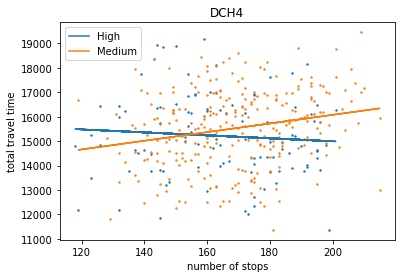

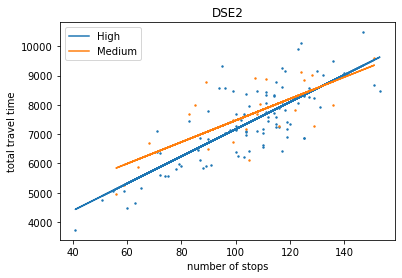

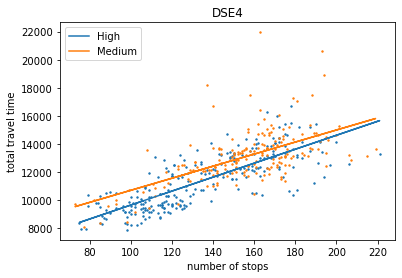

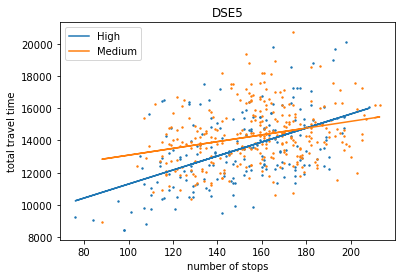

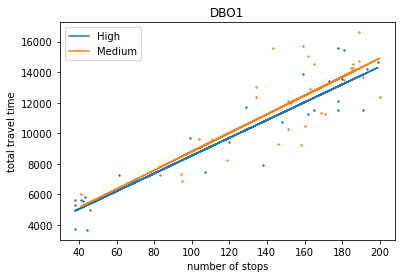

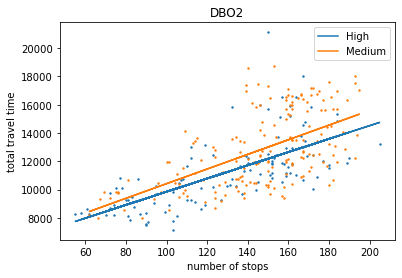

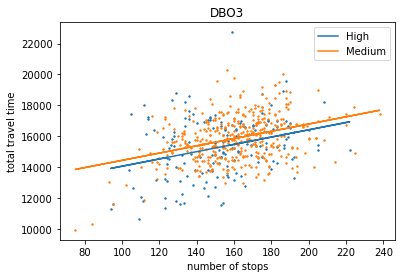

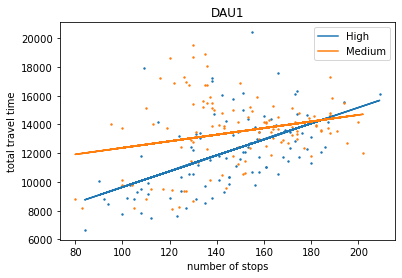

In [14]:
def compute_route_tot_time(key):
    route_seq = act_seq[key]['actual']
    route_list = [k for k, v in sorted(route_seq.items(), key=lambda item: item[1])]
    
    last_stop = route_list[0]
    tot = 0
    for stop in route_list[1:]:
        tot += dist_data[key][last_stop][stop]
        last_stop = stop
        
    tot += dist_data[key][last_stop][route_list[0]]
    return tot

for m in metros:
    for code in metro_to_stations[m]:
        numstop_len_list = collections.defaultdict(list)
        for k, v in route_data.items():
            if k in station_to_id[code]:
                r_type = route_data[k]['route_score']
                numstop_len_list[r_type].append([compute_route_tot_time(k), len(act_seq[k]['actual'])])
        #     print(compute_route_tot_time(k))
        #     print(act_seq[k]['actual']['QX'])
        #     break

        for t in ['High', 'Medium', ]:
            a,b = (zip(*numstop_len_list[t]))
            a, b = np.array(a), np.array(b)
            plt.scatter(b, a, s=2)
            k, c = np.polyfit(b, a, 1)
            plt.plot(b, k*b + c)
            plt.title(code)
        plt.legend(['High', 'Medium', ])
        plt.xlabel('number of stops')
        plt.ylabel('total travel time')
        plt.show()